In [1]:
import os
import pandas as pd
import numpy as np
import tqdm
from typing import Tuple

import cv2
import PIL 

import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from utils import generate_labels, ImagenetteDataset, get_norm_stats,\
                    get_transforms, train, evaluate, train_pipeline, get_augmented_transforms
from models import VGG16, VGG11, VGG_tiny

from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

plt.rcParams['figure.figsize'] = (8.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'

np.random.seed(1234)
torch.manual_seed(1234)

In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [3]:
TRAIN_PATH = 'raw/train'
VAL_PATH = 'raw/val'
TRAIN_LABELS_CSV_PATH = 'raw/train/train_labels.csv'
VAL_LABELS_CSV_PATH = 'raw/val/val_labels.csv'

SAVES_PATH = "saves"

AUGMENT = False

SIZE = 224
batch_size = 16

In [4]:
if 'train_labels.csv' not in os.listdir(TRAIN_PATH):
    generate_labels(TRAIN_PATH, TRAIN_LABELS_CSV_PATH)
if 'val_labels.csv' not in os.listdir(VAL_PATH):
    generate_labels(VAL_PATH, VAL_LABELS_CSV_PATH)

In [4]:
train_labels = pd.read_csv(TRAIN_LABELS_CSV_PATH)
train_labels.drop(columns=['Unnamed: 0'], inplace=True)
train_labels.head()

,filepath,class_name,class_num
0,raw/train/заправка/n03425413_4695.JPEG,заправка,0
1,raw/train/заправка/n03425413_8363.JPEG,заправка,0
2,raw/train/заправка/n03425413_2079.JPEG,заправка,0
3,raw/train/заправка/n03425413_21354.JPEG,заправка,0
4,raw/train/заправка/n03425413_554.JPEG,заправка,0


In [6]:
train_labels.class_name.unique()

array(['заправка', 'хороший мальчик', 'туц', 'язь', 'парашют', 'грузовик',
       'черч', 'гольфомяч', 'труба', 'резня'], dtype=object)

In [7]:
len(train_labels)

9469

In [5]:
val_labels = pd.read_csv(VAL_LABELS_CSV_PATH)
val_labels.drop(columns=['Unnamed: 0'], inplace=True)
len(val_labels)

3925

In [6]:
mean, std = get_norm_stats(TRAIN_LABELS_CSV_PATH)

train_transform, val_transform = get_transforms(mean, std), get_transforms(mean, std)

In [7]:
train_dataset = ImagenetteDataset(TRAIN_LABELS_CSV_PATH, train_transform)

if AUGMENT:
    augmentation_transform = get_augmented_transforms(mean, std)
    augmented_train_dataset = ImagenetteDataset(TRAIN_LABELS_CSV_PATH, augmentation_transform)
    train_dataset = torch.utils.data.ConcatDataset([train_dataset, augmented_train_dataset])
    
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

val_dataset = ImagenetteDataset(VAL_LABELS_CSV_PATH, val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True) 

2


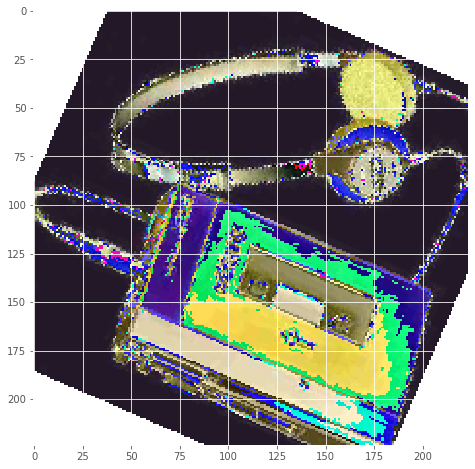

In [20]:
imgs, labels = next(iter(train_dataloader))
transf = T.ToPILImage(mode='RGB')
img = transf(imgs[0])
plt.imshow(img)
print(labels[0].item())

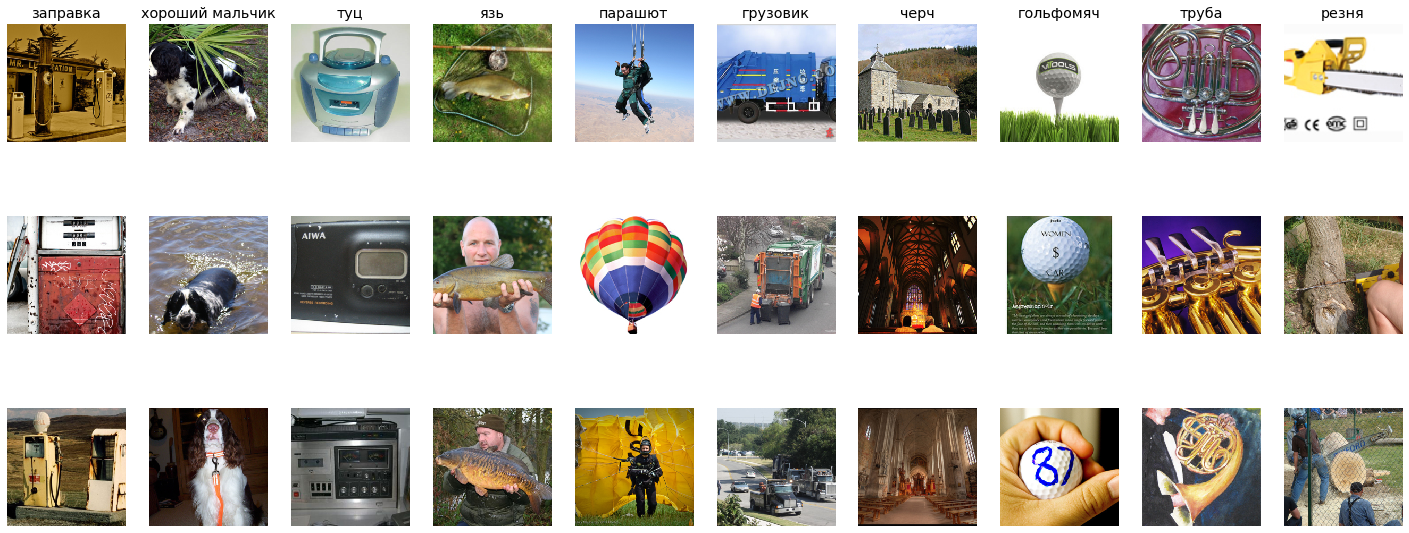

In [21]:
classes = list(train_labels['class_name'].unique())
num_classes = len(classes)
samples_per_class = 3

transform = T.Compose([
    T.Resize(SIZE), 
    T.CenterCrop(SIZE)
])

n_col, n_row = num_classes, samples_per_class
plt.figure(figsize=(25, 10))
for y, label in enumerate(classes):
    ids = np.random.choice(train_labels.loc[train_labels['class_name']==label].index, samples_per_class)
    for i, idx in enumerate(ids):
        img = PIL.Image.open(train_labels.iloc[ids[i]]['filepath'])
        img = transform(img)
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(img)
        plt.axis('off')
        if i == 0:
            plt.title(label)
    

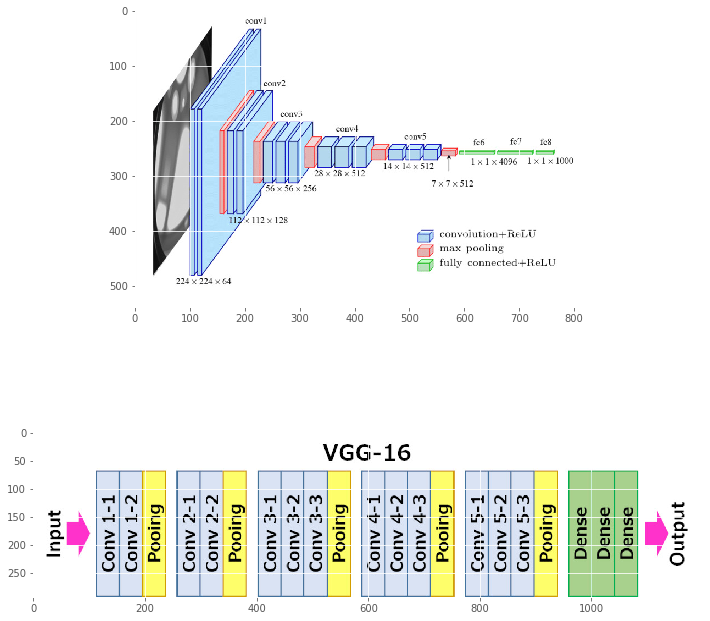

In [23]:
vgg_im1 = PIL.Image.open('models/vgg1.jpg')
vgg_im2 = PIL.Image.open('models/vgg2.jpg')

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.imshow(vgg_im1)
plt.subplot(2, 1, 2)
plt.imshow(vgg_im2)
plt.show()

In [34]:
if 'vgg' in locals():
    del vgg

In [9]:
N_EPOCHS = 15

In [10]:
class_names = [name for name in os.listdir(TRAIN_PATH) if name not in ['.ipynb_checkpoints', 'train_labels.csv']]
num_to_name = dict(zip(range(len(class_names)), class_names))

In [11]:
vgg = VGG11()
vgg.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(), lr=1e-4, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, min_lr=1e-7)

In [39]:
# ckpt = torch.load('saves/ckpts/vgg_tiny_augmented_model.pt')
# vgg = VGG_tiny()
# vgg.load_state_dict(ckpt)
# vgg.to(device)
# optimizer = optim.Adam(vgg.parameters(), lr=1e-5, weight_decay=5e-4)

In [ ]:
train_pipeline(n_epochs=N_EPOCHS, model=vgg, train_iterator=train_dataloader, val_iterator=val_dataloader,
               optimizer=optimizer, criterion=loss, saves_path=SAVES_PATH,
               num_to_name=num_to_name, device=device, scheduler=scheduler,
               model_name='vgg_11_new')

In [41]:
import pickle
with open('saves/losses/accuracy_vgg_tiny_augmented_addition.pickle', 'rb') as f:
    accuracy_history = pickle.load(f)
print(accuracy_history[-1])

0.7156687898089172


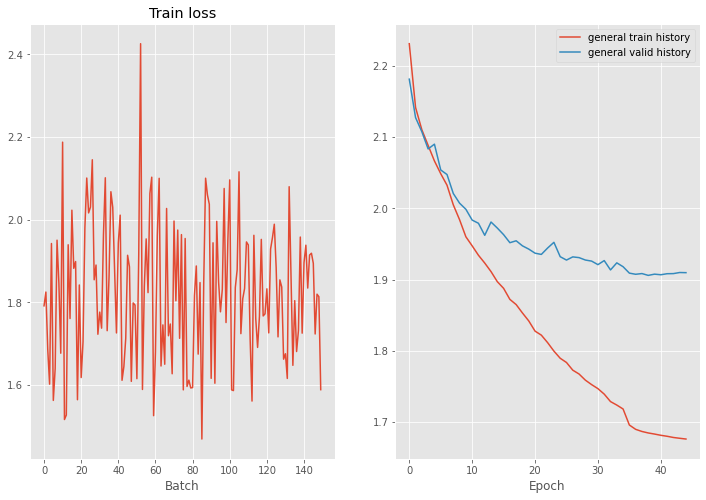

KeyboardInterrupt: 

In [157]:
for epoch in range(ADD_EPOCHS):
    
    train_loss = train(vgg, train_dataloader, optimizer, loss, train_history, valid_history)
    valid_loss = evaluate(vgg, val_dataloader, loss)
    scheduler.step(valid_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(vgg.state_dict(), os.path.join(CKPT_PATH, 'vgg11model.pt'))
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)

In [155]:
# train_history.pop()
valid_history.pop()

1.9461789573040125

In [145]:
import pickle
with open(os.path.join(CKPT_PATH, 'train_loss_vgg11.pickle'), 'wb') as f:
    pickle.dump(train_history, f)
with open(os.path.join(CKPT_PATH, 'val_loss_vgg11.pickle'), 'wb') as f:
    pickle.dump(valid_history, f)

In [147]:
predictions = pd.DataFrame(columns=['true_num', 'pred_num', 'true_name', 'pred_name'])
vgg.eval()

with torch.no_grad():

    for i, (imgs, labels) in enumerate(val_dataloader):

        imgs = imgs.to(device)
        output = vgg(imgs).detach().cpu().numpy() 
        preds = output.argmax(axis=1)
        
        batch_preds = pd.DataFrame({'true_num': labels, 'pred_num': preds})
        predictions = predictions.append(batch_preds, ignore_index=True)
    
predictions['pred_name'] = predictions['pred_num'].apply(lambda x: num_to_name[x])
predictions['true_name'] = predictions['true_num'].apply(lambda x: num_to_name[x])
predictions.head()

,true_num,pred_num,true_name,pred_name
0,6,6,черч,черч
1,0,0,заправка,заправка
2,8,6,труба,черч
3,8,8,труба,труба
4,1,4,хороший мальчик,парашют


In [148]:
accuracy_score(predictions['true_num'].astype(int), predictions['pred_num'].astype(int))

0.5464968152866242

In [137]:
predictions

0       7
1       4
2       1
3       7
4       7
       ..
3920    9
3921    5
3922    1
3923    9
3924    6
Name: true_num, Length: 3925, dtype: int64

In [ ]:
#TODO:

# репа гх
# тензорборд / свои графики 
# метрики в график
# cv: schedulerы, linear dim, layers_num, dropout
# augmentation 
# sequential
# blocks nn
# modules 
# configs 

# resnet/next/se/etc